# Lab 2
### *C4.5 decicion tree* vs *naive bayes classification*
breast-cancer.arff



In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib
import graphviz
import sklearn as sk

from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB


##### Dataset Loading

In [36]:
data = arff.loadarff('breast-cancer.arff')
df = pd.DataFrame(data[0]).select_dtypes([np.object]).stack().str.decode('utf-8').unstack()
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


Since we have some patterns with missiong values, we decided to eliminate them from the dataset

In [37]:
df.iloc[20:21,] # row with missing data

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
20,50-59,lt40,20-24,0-2,?,1,left,left_low,no,recurrence-events


In [38]:
df = df[(df['node-caps'] != '?') & (df['breast-quad'] != '?')]

Now we transform the dataset by factorizing it, so to replace the string values for the features to numbers

In [39]:
cats = {}
codes, cats['age'] = pd.factorize(df['age'])
df.loc[:,'age'] = codes
codes, cats['menopause'] = pd.factorize(df['menopause'])
df.loc[:,'menopause'] = codes
codes, cats['tumor-size'] = pd.factorize(df['tumor-size'])
df.loc[:,'tumor-size'] = codes
codes, cats['inv-nodes'] = pd.factorize(df['inv-nodes'])
df.loc[:,'inv-nodes'] = codes
codes, cats['node-caps'] = pd.factorize(df['node-caps'])
df.loc[:,'node-caps'] = codes
codes, cats['breast'] = pd.factorize(df['breast'])
df.loc[:,'breast'] = codes
codes, cats['breast-quad'] = pd.factorize(df['breast-quad'])
df.loc[:,'breast-quad'] = codes
codes, cats['irradiat'] = pd.factorize(df['irradiat'])
df.loc[:,'irradiat'] = codes
codes, cats['Class'] = pd.factorize(df['Class'])
df.loc[:,'Class'] = codes
df.loc[:,'deg-malig'] = df['deg-malig'].astype(int)


Now we can compute the correlation matrix 

In [40]:
corrMat = df.corr()
corrMat.style.background_gradient(cmap='coolwarm')

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
age,1.000000,0.242579,-0.031988,-0.029323,0.036850,-0.019273,0.073121,-0.018384,-0.029499,-0.023966
menopause,0.242579,1.000000,0.006746,-0.035095,0.048569,0.040020,0.059217,-0.092046,-0.093481,0.087480
tumor-size,-0.031988,0.006746,1.000000,-0.105610,0.078192,-0.103100,-0.020722,-0.047194,0.005344,0.079440
inv-nodes,-0.029323,-0.035095,-0.105610,1.000000,-0.632495,0.333198,0.021855,0.080266,0.370313,-0.317881
node-caps,0.036850,0.048569,0.078192,-0.632495,1.000000,-0.330181,-0.012345,-0.043770,-0.333537,0.289002
deg-malig,-0.019273,0.040020,-0.103100,0.333198,-0.330181,1.000000,0.045874,-0.040290,0.230821,-0.330253
breast,0.073121,0.059217,-0.020722,0.021855,-0.012345,0.045874,1.000000,0.168374,-0.025230,-0.041304
breast-quad,-0.018384,-0.092046,-0.047194,0.080266,-0.043770,-0.040290,0.168374,1.000000,-0.006060,-0.055458
irradiat,-0.029499,-0.093481,0.005344,0.370313,-0.333537,0.230821,-0.025230,-0.006060,1.000000,-0.226020
Class,-0.023966,0.087480,0.079440,-0.317881,0.289002,-0.330253,-0.041304,-0.055458,-0.226020,1.000000


By this results we can say that age and breast appear not to be correlated to much with the target class. So we will try to eliminate those features from the dataset and see if we could get any improvements.

In [41]:
#Splitting the target class from the features
df.head()
Y = df['Class']
X = df.iloc[:,:-1]

Functions for reduction, permutation and splitting of the dataset

In [42]:
#This function is used to eliminate some features from the dataset, in this case we eliminate breast, age andboth togheter.
#Returning 3 different datasets
def reducedDatasets (X,Y) :

    #Datasets with feature reduction
    X_breast = X[X.columns.difference(['age'])]
    X_age = X[X.columns.difference(['breast'])]
    X_breast_age = X[X.columns.difference(['age','breast'])]

    
    return X,X_breast,X_age,X_breast_age,Y

#This function does a permutation on the dataset, is good to test multiple instances of datasets
def permuteDataset(X,Y) :
    m = X.shape[0]
    permutation = np.random.permutation(m) # random permutation

    X = X.iloc[permutation]
    Y = Y.iloc[permutation]
    return X,Y

#This funcion is used to split the whole dataset between training and testing
def splitDataset (X,Y,ratio) :
    
    #patterns in the test set
    m = X.shape[0]
    m_training = round(m*ratio)
    m_test = m-m_training
    X_training = []
    Y_training = []
    X_test = []
    Y_test = []
    #X_training = instances for training set
    X_training = X[0:m_training] 

    #Y_training = labels for the training set
    Y_training = Y[0:m_training]

    #X_test = instances for test set
    X_test = X[m_training-1:-1]

    #Y_test = labels for the test set
    Y_test = Y[m_training-1:-1]
    
    return X_training,Y_training,X_test,Y_test

### Decision Tree implementation

We used the sklearn library for the implementation of the decision tree. The library makes the implementation very easy, we just need to define a   DecisionTreeClassifier object, than we fit the model on the training set selected, finally we can use the function score to compute the overall accuracy on the model.

In [203]:

#without features reduction
clf = tree.DecisionTreeClassifier()
X_training,Y_training,X_test,Y_test = splitDataset(X,Y,0.8)
clf = clf.fit(X_training, Y_training)


In [204]:
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("decisiontree")

'decisiontree.pdf'

### try pruning

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

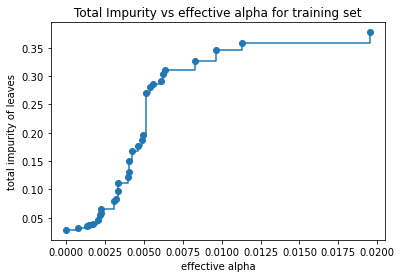

In [205]:
# calculate and plot the cost complexity pruning path
X,Y = permuteDataset(X,Y)
X,X_b,X_a,X_ab,Y = reducedDatasets (X,Y)
X_training,Y_training,X_test,Y_test = splitDataset(X,Y,0.8)

path = clf.cost_complexity_pruning_path(X_training, Y_training)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [206]:
# fit the model with all alphas and save them into an array
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_training, Y_training)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.05104348234978878


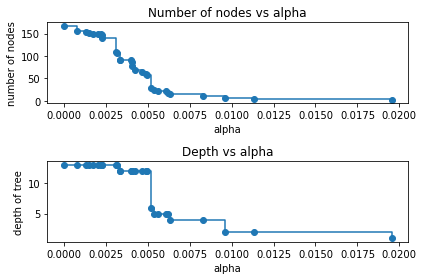

In [207]:
# plot the depth and node counts for the different alphas (excluding the last values with only one node)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

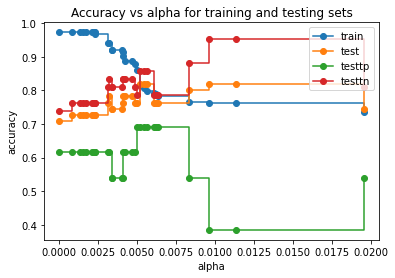

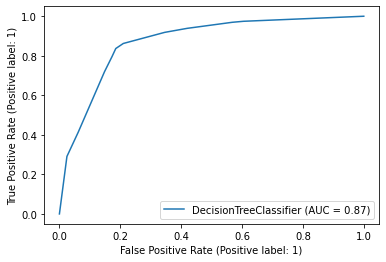

In [210]:
# score the different alphas and plot the train- and testscores
train_scores = [clf.score(X_training, Y_training) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

def calc_cm(clf, X, Y_true):
    Y_pred = clf.predict(X)
    return sk.metrics.confusion_matrix(Y_true, Y_pred, normalize='true')


test_tp = [calc_cm(clf, X_test, Y_test)[0][0] for clf in clfs]
test_tn = [calc_cm(clf, X_test, Y_test)[1][1] for clf in clfs]
best_clf = clfs[test_tp.index(max(test_tp))]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_tp, marker='o', label="testtp",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_tn, marker='o', label="testtn",
        drawstyle="steps-post")
sk.metrics.plot_roc_curve(best_clf,X,Y)
ax.legend()
plt.show()

In [198]:
#without age
X_training_age= X_training[X_training.columns.difference(['age'])]
X_test_age= X_test[X_test.columns.difference(['age'])]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_training_age, Y_training)
acc = clf.score( X_test_age, Y_test)

print(acc)

0.5818181818181818


In [189]:
#without breast
X_training_breast= X_training[X_training.columns.difference(['breast'])]
X_test_breast= X_test[X_test.columns.difference(['age'])]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_training_breast, Y_training)
acc = clf.score( X_test_breast, Y_test)

print(acc)

0.6181818181818182


In [161]:
#without age & breast
X_training_age_breast= X_training[X_training.columns.difference(['age','breast'])]
X_test_age_breast= X_test[X_test.columns.difference(['age','breast'])]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_training_age_breast, Y_training)
acc = clf.score( X_test_age_breast, Y_test)

print(acc)

0.6727272727272727


### Cross Validation results

In [45]:
nFolds= 10

In [46]:
#No feature reduction
clf = tree.DecisionTreeClassifier()
accs=cross_val_score(clf, X, Y, cv=nFolds)
np.average(accs)

0.6284391534391535

In [47]:
clf = tree.DecisionTreeClassifier()
accs_age=cross_val_score(clf, X_age, Y, cv=nFolds)
np.average(accs_age)

NameError: name 'X_age' is not defined

In [48]:
clf = tree.DecisionTreeClassifier()
accs_breast=cross_val_score(clf, X_breast, Y, cv=nFolds)
np.average(accs_breast)

NameError: name 'X_breast' is not defined

In [526]:
clf = tree.DecisionTreeClassifier()
accs_breast_age=cross_val_score(clf, X_breast_age, Y, cv=nFolds)
np.average(accs_breast_age)

0.6537037037037037

### ATTENTION !!
##### This code is a batch computation, it' very heavy and takes a lot of time to compute, don't execute it if not necessary.

In [27]:
nFolds= 10
nPermutation = 100
nTrials = 50
avgAccs = np.zeros( (4, nPermutation, nTrials) )
for p in range(nPermutation) :
    print("Permutation " + str(p))
    X, X_breast ,X_age, X_breast_age, Y = reducedDatasets ()
    for t in range(nTrials) :
        clf = tree.DecisionTreeClassifier()
        avgAccs[0,p,t] = np.average(cross_val_score(clf, X, Y, cv=nFolds))
        clf = tree.DecisionTreeClassifier()
        avgAccs[1,p,t] = np.average(cross_val_score(clf, X_age, Y, cv=nFolds))
        clf = tree.DecisionTreeClassifier()
        avgAccs[2,p,t] = np.average(cross_val_score(clf, X_breast, Y, cv=nFolds))
        clf = tree.DecisionTreeClassifier()
        avgAccs[3,p,t] = np.average(cross_val_score(clf, X_breast_age, Y, cv=nFolds))     

Permutation 0
Permutation 1
Permutation 2
Permutation 3
Permutation 4
Permutation 5
Permutation 6
Permutation 7
Permutation 8
Permutation 9
Permutation 10
Permutation 11
Permutation 12
Permutation 13
Permutation 14
Permutation 15
Permutation 16
Permutation 17
Permutation 18
Permutation 19
Permutation 20
Permutation 21
Permutation 22
Permutation 23
Permutation 24
Permutation 25
Permutation 26
Permutation 27
Permutation 28
Permutation 29
Permutation 30
Permutation 31
Permutation 32
Permutation 33
Permutation 34
Permutation 35
Permutation 36
Permutation 37
Permutation 38
Permutation 39
Permutation 40
Permutation 41
Permutation 42
Permutation 43
Permutation 44
Permutation 45
Permutation 46
Permutation 47
Permutation 48
Permutation 49
Permutation 50
Permutation 51
Permutation 52
Permutation 53
Permutation 54
Permutation 55
Permutation 56
Permutation 57
Permutation 58
Permutation 59
Permutation 60
Permutation 61
Permutation 62
Permutation 63
Permutation 64
Permutation 65
Permutation 66
Permu

In [529]:
print("NORMAL DATASET   acc: " + str(np.average(np.average(avgAccs[0,:,:]))))
print("NO AGE           acc: " + str(np.average(np.average(avgAccs[1,:,:]))))
print("NO BREAST        acc: " + str(np.average(np.average(avgAccs[2,:,:]))))
print("NO AGE & BREAST  acc: " + str(np.average(np.average(avgAccs[3,:,:]))))

NORMAL DATASET   acc: 0.6461523544973544
NO AGE           acc: 0.6481156084656085
NO BREAST        acc: 0.655572037037037
NO AGE & BREAST  acc: 0.66392


From the results above we can confidently say that age and breast are not so importanto for the classification problem when decision tree is used.

##### Cofusion matrix for decsion tree with feature reduction

NORMAL
NO AGE
NO BREAST
NO AGE&BREAST


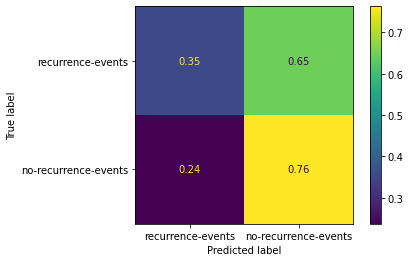

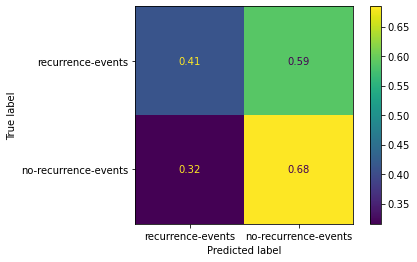

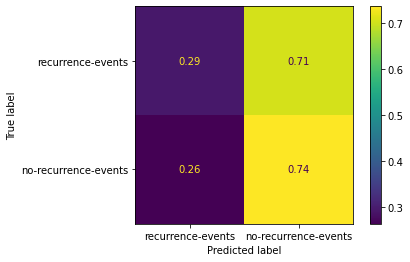

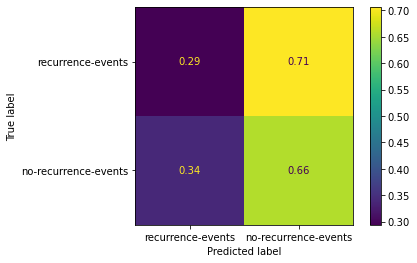

In [27]:
clf = tree.DecisionTreeClassifier()
Y = df['Class']
X = df.iloc[:,:-1]
X,Y = permuteDataset(X,Y)
X,X_breast,X_age,X_breast_age,Y = reducedDatasets (X,Y)
X_train,Y_train,X_test,Y_test = splitDataset(X,Y,0.8)
X_train_a,Y_train_a,X_test_a,Y_test_a = splitDataset(X_age,Y,0.8)
X_train_b,Y_train_b,X_test_b,Y_test_b = splitDataset(X_breast,Y,0.8)
X_train_ab,Y_train_ab,X_test_ab,Y_test_ab = splitDataset(X_breast_age,Y,0.8)

print("NORMAL")
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)
sk.metrics.plot_confusion_matrix(clf, X_test, Y_test,normalize='true', display_labels = cats['Class'])

print("NO AGE")
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_a, Y_train_a)
sk.metrics.plot_confusion_matrix(clf, X_test_a, Y_test_a,normalize='true', display_labels = cats['Class'])

print("NO BREAST")
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_b, Y_train_b)
sk.metrics.plot_confusion_matrix(clf, X_test_b, Y_test_b,normalize='true', display_labels = cats['Class'])

print("NO AGE&BREAST")
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_ab, Y_train_ab)
sk.metrics.plot_confusion_matrix(clf, X_test_ab, Y_test_ab,normalize='true', display_labels = cats['Class'])

### Nyve Bayas implementation


### ATTENTION !!
##### This code is a batch computation, it' very heavy and takes a lot of time to compute, don't execute it if not necessary.

In [559]:
nFolds= 10
nPermutation = 100
nTrials = 50
avgAccsBayes = np.zeros( (4, nPermutation, nTrials) )
for p in range(nPermutation) :
    print("Permutation " + str(p))
    X, X_breast ,X_age, X_breast_age, Y = reducedDatasets ()
    for t in range(nTrials) :
        clf = GaussianNB()
        avgAccsBayes[0,p,t] = np.average(cross_val_score(clf, X, Y, cv=nFolds))
        clf = GaussianNB()
        avgAccsBayes[1,p,t] = np.average(cross_val_score(clf, X_age, Y, cv=nFolds))
        clf = GaussianNB()
        avgAccsBayes[2,p,t] = np.average(cross_val_score(clf, X_breast, Y, cv=nFolds))
        clf = GaussianNB()
        avgAccsBayes[3,p,t] = np.average(cross_val_score(clf, X_breast_age, Y, cv=nFolds))    

Permutation 0
Permutation 1
Permutation 2
Permutation 3
Permutation 4
Permutation 5
Permutation 6
Permutation 7
Permutation 8
Permutation 9
Permutation 10
Permutation 11
Permutation 12
Permutation 13
Permutation 14
Permutation 15
Permutation 16
Permutation 17
Permutation 18
Permutation 19
Permutation 20
Permutation 21
Permutation 22
Permutation 23
Permutation 24
Permutation 25
Permutation 26
Permutation 27
Permutation 28
Permutation 29
Permutation 30
Permutation 31
Permutation 32
Permutation 33
Permutation 34
Permutation 35
Permutation 36
Permutation 37
Permutation 38
Permutation 39
Permutation 40
Permutation 41
Permutation 42
Permutation 43
Permutation 44
Permutation 45
Permutation 46
Permutation 47
Permutation 48
Permutation 49
Permutation 50
Permutation 51
Permutation 52
Permutation 53
Permutation 54
Permutation 55
Permutation 56
Permutation 57
Permutation 58
Permutation 59
Permutation 60
Permutation 61
Permutation 62
Permutation 63
Permutation 64
Permutation 65
Permutation 66
Permu

In [560]:
print("NORMAL DATASET   acc: " + str(np.average(np.average(avgAccsBayes[0,:,:]))))
print("NO AGE           acc: " + str(np.average(np.average(avgAccsBayes[1,:,:]))))
print("NO BREAST        acc: " + str(np.average(np.average(avgAccsBayes[2,:,:]))))
print("NO AGE & BREAST  acc: " + str(np.average(np.average(avgAccsBayes[3,:,:]))))

NORMAL DATASET   acc: 0.7320859788359788
NO AGE           acc: 0.7312142857142857
NO BREAST        acc: 0.731728835978836
NO AGE & BREAST  acc: 0.730813492063492


##### Cofusion matrix for NAYVE BAYES with feature reduction

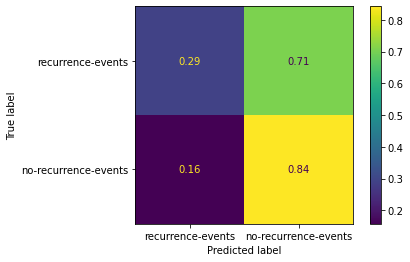

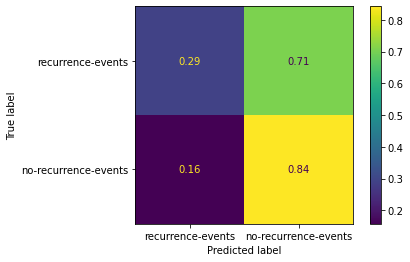

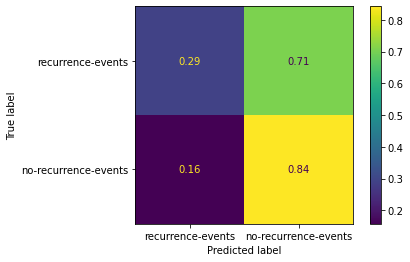

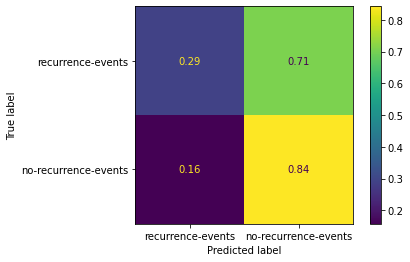

In [29]:

X,X_breast,X_age,X_breast_age,Y = reducedDatasets (X,Y)
X_train,Y_train,X_test,Y_test = splitDataset(X,Y,0.8)
X_train_a,Y_train_a,X_test_a,Y_test_a = splitDataset(X_age,Y,0.8)
X_train_b,Y_train_b,X_test_b,Y_test_b = splitDataset(X_breast,Y,0.8)
X_train_ab,Y_train_ab,X_test_ab,Y_test_ab = splitDataset(X_breast_age,Y,0.8)
clf = GaussianNB()
clf.fit(X_train, Y_train)
sk.metrics.plot_confusion_matrix(clf, X_test, Y_test,normalize='true', display_labels = cats['Class'])
clf = GaussianNB()
clf.fit(X_train_a, Y_train_a)
sk.metrics.plot_confusion_matrix(clf, X_test_a, Y_test_a,normalize='true', display_labels = cats['Class'])
clf = GaussianNB()
clf.fit(X_train_b, Y_train_b)
sk.metrics.plot_confusion_matrix(clf, X_test_b, Y_test_b,normalize='true', display_labels = cats['Class'])
clf = GaussianNB()
clf.fit(X_train_ab, Y_train_ab)
sk.metrics.plot_confusion_matrix(clf, X_test_ab, Y_test_ab,normalize='true', display_labels = cats['Class'])